In [88]:
%run tools.ipynb

In [89]:
import pytz
from tzwhere import tzwhere


In [90]:
# Moch's data
#fname = '../data/ozone/moch/GCHP.Health_hr.5Yavg_SpeciesConc_O3_2x25.nc4'
fname = '../data/ozone/moch/geoE.Health_hr.5Yavg_SpeciesConc_O3_2x25.nc4'

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:         (lat: 91, lev: 1, lon: 144, time: 8784)
Coordinates:
  * lon             (lon) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lev             (lev) float64 1.0
  * lat             (lat) float64 -89.5 -88.0 -86.0 -84.0 ... 86.0 88.0 89.5
  * time            (time) datetime64[ns] 2016-01-01T00:30:00 ... 2016-12-31T23:30:00
Data variables:
    SpeciesConc_O3  (time, lev, lat, lon) float32 ...
Attributes:
    regrid_method:  conservative

In [91]:
# plot XY range
lat1 = 18
lat2 = 55
lon1 = 72 #+ 180
lon2 = 135 #+ 180

In [92]:
dr_tmp = ds['SpeciesConc_O3'].isel(lev = 0)
dr_tmp_scaled = dr_tmp*1e9
dr_mean = dr_tmp_scaled.mean(dim = 'time') # unit convert to ppb


In [93]:
# China provincial borders 
with open(r'/Users/mehliyarsadiq/Desktop/ozone_crop/data/CN-border-La.dat') as src:
    context = ''.join([line for line in src if not line.startswith('#')])
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


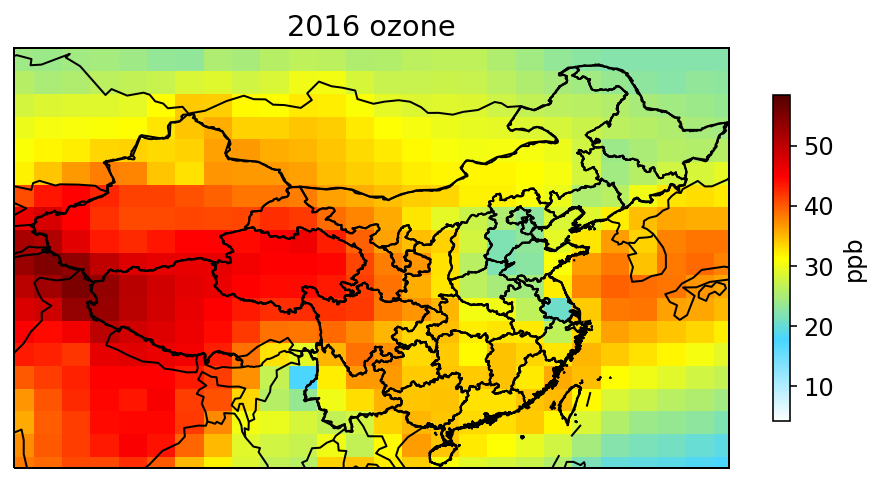

In [94]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=[8, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
dr_mean.plot(ax = ax,
                  transform=ccrs.PlateCarree(), 
                  cmap=WhGrYlRd, 
                  #vmin = 200,
                  #vmax = 320,
                  cbar_kwargs={'shrink': 0.5, 'label': 'ppb'})

ax.set_xlim(lon1,lon2)
ax.set_ylim(lat1,lat2)
ax.set_title('2016 ozone')
ax.add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())


In [95]:
# a function for time zone conversion
#def time_zone_shift(dr):
dr_tmp_scaled
new_dr = dr_tmp_scaled.copy()
new_dr[:,:,:] = 0.

for ilon, lon in enumerate(new_dr.lon.values):
    xlon = math.ceil(lon / 15)
    #print(ilon, lon, math.ceil(lon / 15), np.shape(np.roll(dr_tmp_scaled[:,:,ilon].values, xlon, axis = 0)))
    shift = np.roll(dr_tmp_scaled[:,:,ilon].values, xlon, axis = 0)
    new_dr[:,:,ilon] = shift
    

In [100]:
#new_mean = new_dr.mean(dim = 'time')
#diff = new_mean - dr_mean
#diff.plot()

#first_day_mean = dr_tmp_scaled[:7,:,:].mean(dim = 'time')
#first_day_new = new_dr[:7,:,:].mean(dim = 'time')
#diff = first_day_mean - first_day_new
#diff.plot()

In [99]:
#ilat = 0
#np.shape(dr_tmp_scaled[:,ilat,ilon].values)
#shift = np.roll(dr_tmp_scaled[:,ilat,ilon].values, xlon)
#shift = np.roll(dr_tmp_scaled[:,:,ilon].values, xlon, axis = 0)
#plt.plot(dr_tmp_scaled[:,ilat,ilon].values[:168], c = 'black')
#plt.plot(shift[:168,ilat])

In [103]:
ds_new = new_dr.to_dataset(name = 'SpeciesConc_O3_localtime')
ds_new.to_netcdf('../data/ozone/moch/geoE.localtime.nc4')